<a href="https://colab.research.google.com/github/kumar-devesh/DETR/blob/master/notebooks/DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xmltodict

In [2]:
import os
import itertools
import PIL
from tqdm import tqdm
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
from torchvision.datasets import VOCDetection

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
import xmltodict

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [36]:
batch_size = 2
dir_path='/content/drive/MyDrive/Colab Notebooks/detr'
os.chdir(dir_path)

In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Dataset

In [7]:
def plotImage(image):
  image = np.array(image)
  plt.imshow(np.transpose(image,(1,2,0)))

In [8]:
def plotGrid(images):
  img_grid = torchvision.utils.make_grid(images, nrow=4)
  img_grig = np.array(img_grid)
  img_grid = np.transpose(img_grid,(1,2,0))
  plt.imshow(img_grid)

In [9]:
def convert_xml_to_dict(path):
  """ converts xml file to a dictionary """
  fileptr = open(path,"r")
  xml = fileptr.read()
  
  #change xml format to ordered dict
  xml_to_dict = xmltodict.parse(xml)
  return xml_to_dict

In [10]:
def normalize_image(image):
  mean = (0,0,0)
  std = (1,1,1)
  brightness, contrast, saturation, hue = 0.25*np.random.random_sample((4,))
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness= brightness, contrast=contrast, saturation=saturation, hue=hue),
    transforms.Normalize(mean, std)])
  return transform(image)

In [52]:
class VOC(Dataset):
  def __init__(self, img_dir, annotation_dir, normalize = True):
    self.img_dir = img_dir
    self.annotation_dir = annotation_dir
    self.img_list = os.listdir(img_dir)
    self.annotation_list = os.listdir(annotation_dir)
    self.normalize = normalize

  def __len__(self):
    return len(self.img_list)

  def getbbox(self, dct_item_list):
    bndbox_list = []
    name_list = []
    for dct_item in dct_item_list:
      dct_bndbox = dct_item['bndbox']
      bndbox_list.append([float(dct_bndbox['xmin']['#text']), float(dct_bndbox['ymin']['#text']), float(dct_bndbox['xmax']['#text']), float(dct_bndbox['ymax']['#text'])])
      name = dct_item['name']['#text']
      name_list.append(name)
    return {'name': name_list, 'bbox': bndbox_list}
 
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_list[idx])
    image = Image.open(img_path)
    image = np.array(image)/255
    if self.normalize is True:
      image = normalize_image(image)
    else:
      image = np.transpose(image,(2,0,1))
    image = torch.tensor(image, dtype=torch.float32, requires_grad=False)

    annotation_path = os.path.join(self.annotation_dir, self.annotation_list[idx])
    annotation = convert_xml_to_dict(annotation_path)
    dct_item_list = annotation['root']['annotation']['object']['item']
    if isinstance(dct_item_list, dict):
      temp =[]
      temp.append(dct_item_list)
      dct_item_list = temp
    annotations = [self.getbbox(dct_item_list)]
    print(annotations)
    return image

In [53]:
train_img_dir = os.path.join(dir_path, 'dataset/processed/images/train')
train_annotation_dir = os.path.join(dir_path, 'dataset/processed/annotations/train')

In [54]:
val_img_dir = os.path.join(dir_path, 'dataset/processed/images/val')
val_annotation_dir = os.path.join(dir_path, 'dataset/processed/annotations/val')

In [55]:
train_data = VOC(img_dir=train_img_dir, annotation_dir = train_annotation_dir) #dataset
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[{'name': ['aeroplane'], 'bbox': [[0.512, 0.7485380116959064, 256.0, 256.0]]}]
[{'name': ['dog'], 'bbox': [[2.2116630669546438, 2.56, 253.78833693304537, 256.0]]}]
[{'name': ['sheep'], 'bbox': [[1.024, 16.155339805825243, 242.68800000000002, 255.99999999999997]]}]
[{'name': ['diningtable', 'chair', 'chair', 'person', 'person', 'person', 'chair', 'chair', 'person'], 'bbox': [[55.808, 136.53333333333333, 256.0, 256.0], [0.512, 176.81066666666666, 100.864, 256.0], [0.512, 144.04266666666666, 95.744, 256.0], [19.968, 81.92, 111.616, 256.0], [53.76, 63.488, 106.49600000000001, 153.6], [135.168, 75.09333333333333, 184.832, 154.28266666666667], [178.68800000000002, 109.22666666666666, 196.608, 131.75466666666665], [221.696, 118.10133333333333, 256.0, 256.0], [182.784, 74.41066666666667, 231.936, 172.03199999999998]]}]
[{'name': ['diningtable', 'person', 'person', 'person'], 'bbox': [[1.024, 210.64264264264264, 256.0, 256.0], [0.512, 0.7687687687687688, 111.616, 256.0], [88.57600000000001, 93.

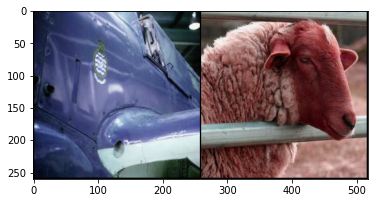

In [58]:
image = next(iter(train_loader))
plotGrid(image)

In [57]:
val_data = VOC(img_dir = val_img_dir, annotation_dir = val_annotation_dir) #dataset
val_loader = DataLoader(val_data, batch_size, shuffle=True, num_workers=2)

## MODEL

### conv backbone

In [ ]:
backbone = models.resnet18(pretrained=True)

In [ ]:
class ResNetBackbone(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = backbone.conv1
    self.bn1 = backbone.bn1
    self.relu = backbone.relu
    self.maxpool = backbone.maxpool
    self.layer1 = backbone.layer1
    self.layer2 = backbone.layer2
    self.layer3 = backbone.layer3
    self.layer4 = backbone.layer4

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

In [ ]:
model_bb = ResNetBackbone()
print(model_bb)

In [ ]:
model_bb.conv1 = backbone.conv1
model_bb.bn1 = backbone.bn1
model_bb.relu = backbone.relu
model_bb.maxpool = backbone.maxpool
model_bb.layer1 = backbone.layer1
model_bb.layer2 = backbone.layer2
model_bb.layer3 = backbone.layer3
model_bb.layer4 = backbone.layer4

In [ ]:
inp = torch.randn([batch_size, 3, 224, 224])
print(inp.size())
out = model_bb(inp)
print(out.size())

In [ ]:
for param in model_bb.parameters():
    param.requires_grad = False

### transformer model hyperparameters


In [ ]:
h = 8
batch_size = 2
seq_len=50
d_model = 128
d_k = d_q = d_v = d_model//h
d_ff = 2048
n_blocks = 3
src_vocab_size = 1000
tgt_vocab_size = 1000

### transformer

### **Positional Encoding:**

Since the model contains no convolutions or recursion to make use of order of the sequence, positional encodings are used.

input dimensions: (batch_size, seq_len, d_model)

In [ ]:
# positional encoding
class PositionalEncoding(nn.Module):
  """ input: tensor x
      output: tensor x + position encoding """
  def __init__(self, max_len = 50):
    super(PositionalEncoding, self).__init__()
    self.max_len = max_len

    arr = np.ones((max_len, d_model))
  
    pos = np.arange(max_len).reshape(max_len, 1)
    pos = arr*pos

    i = np.arange(0, d_model, 1)
    p = arr*(i.reshape(1, d_model))/d_model

    x = pos/np.power(10000, p)
    sin_mask = np.ones(d_model)
    sin_mask[1:d_model:2] = 0
    cos_mask = np.ones(d_model)
    cos_mask[0:d_model:2] = 0
    self.pe = sin_mask.reshape(1, d_model)*np.sin(x)+cos_mask.reshape(1, d_model)*np.cos(x)
    self.pe = torch.from_numpy(self.pe)
    self.pe = torch.unsqueeze(input = self.pe, dim=0)

  def forward(self, x):
    x = x + self.pe
    return x

In [ ]:
sns.set()
seq_len=50
pe = PositionalEncoding(max_len = seq_len)
x = torch.randn(size = [batch_size, seq_len, d_model])
a = pe(x = 0)
print(a.size())

torch.Size([1, 50, 128])


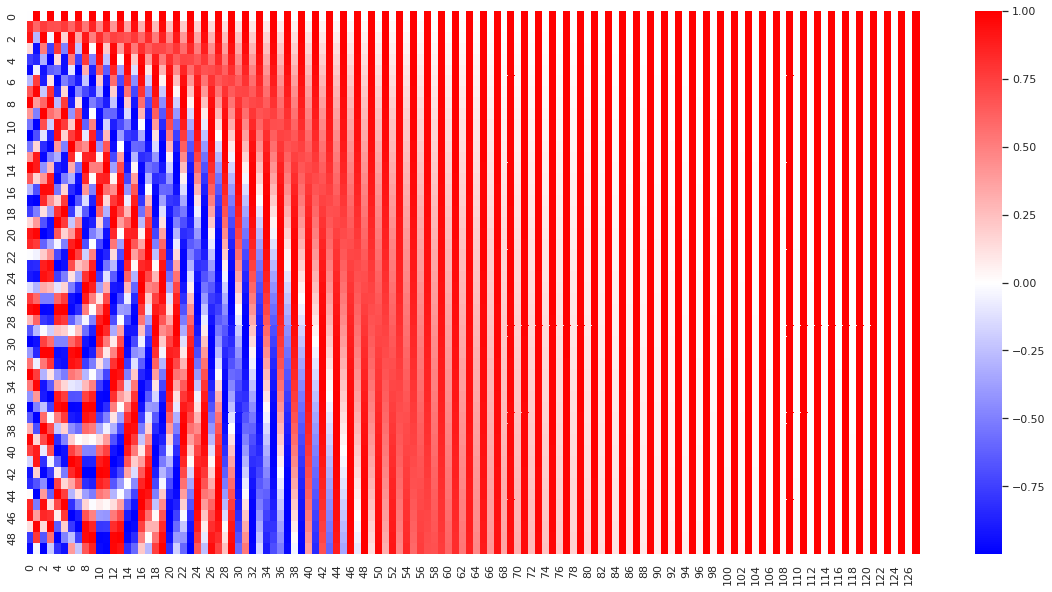

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(a[0], cmap="bwr")

### transformer

In [ ]:
class Transformer(nn.Module):
  def __init__(self, d_model = 512, num_heads = 8, d_ff = 2048, encoder_layers = 4, decoder_layers = 4, batch_first=True):
    super(Transformer, self).__init__()

    decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff, dropout=0.1, batch_first=True)
    self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_layers)

    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=2048, dropout=0.1, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=encoder_layers)

  def forward(self, input):
    x = self.transformer_encoder(input)
    x = self.transformer_decoder(x)
    return x

### prediction heads

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim = d_model, hidden_dim = d_model, output_dim = 4, num_layers = 3):
    super(MLP, self).__init__()
    self.layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace = True)]
    for i in range(num_layers-2):
      self.layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace = True)]
    self.layers += [nn.Linear(hidden_dim, output_dim), nn.ReLU(inplace = True)]
    self.mlp = nn.Sequential(*self.layers)

  def forward(self, x):
    x = self.mlp(x)
    return x

In [ ]:
class PredictionHeads(nn.Module):
  def __init__(self, num_classes = 20):
    super(PredictionHeads, self).__init__()
    self.class_layer = nn.Linear(d_model, num_classes+1)
    self.bbox_layer = MLP(hidden_dim = d_model)

  def forward(self, input):
    class_logits = self.class_layer(input)
    bbox = bbox_layer(input)
    out = {'class_logits':class_logits, 'bbox':bbox}
    return out

### DETR

In [ ]:
# trainable model weights (except resnet backbone)

In [ ]:
class DETR(nn.Module):
  def __init__(self, batch_size, num_channels, num_classes):
    super(DETR, self).__init__()

    self.batch_size = batch_size
    self.num_channels = num_channels

    self.pe = PositionalEncoding(max_len = num_channels)
    self.pred_head = PredictionHeads(num_classes = num_classes)
    self.transformer = Transformer(d_model = 512, num_heads = 8, d_ff = 2048, encoder_layers = 4, decoder_layers = 4, batch_first=True)

  def forward(self, feature_maps):
    x = feature_maps.view(self.batch_size, self.num_channels, -1)
    x = self.pe(x)
    x = self.transformer(x)
    x = self.pred_head(x)
    return x

In [ ]:
detr = DETR()

In [ ]:
print(detr)

### bipartite matching

In [ ]:
# hungarian algorithm

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Modules to compute the matching cost and solve the corresponding LSAP.
"""
import torch
from scipy.optimize import linear_sum_assignment
from torch import nn

from util.box_ops import box_cxcywh_to_xyxy, generalized_box_iou


class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher
        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


def build_matcher(args):
    return HungarianMatcher(cost_class=args.set_cost_class, cost_bbox=args.set_cost_bbox, cost_giou=args.set_cost_giou)

## train

In [ ]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 20

In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(Gxy.parameters(), Gyx.parameters()), lr= lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(itertools.chain(Dx.parameters(), Dy.parameters()), lr= lr, betas=(beta1, beta2))

In [ ]:
def get_gradient_norm(model):
  for p in model.parameters():
    param_norm = p.grad.detach().data.norm(2)
    total_norm += param_norm.item()**2
  total_norm = total_norm**0.5
  return total_norm

In [ ]:
def add_images_to_tensorboard(iteration):
  zebra_images = Gxy(get_horse_images().to(device)).clone().detach().to('cpu')
  horse_images = Gyx(get_zebra_images().to(device)).clone().detach().to('cpu')
  images = [*horse_images[0:4], *zebra_images[0:4]]
  img_grid = torchvision.utils.make_grid(images, nrow=4)
  writer.add_image('image-generated at epoch'+str(epoch), img_grid)

In [ ]:
def train(epoch, lambda_cyc=10, k=1, iterations = 125):
  for iteration in range(iterations):
    #Update the Discriminators k steps
    x = 125*epoch + iteration
    for i in range(k):
      optimizer_D.zero_grad()

      real_x = get_horse_images().clone().detach().to(device)
      adversarial_loss = LS_loss(D_real_images = Dx(real_x), D_generated_images = Dy(Gxy(real_x)), generator_loss = False)
      adversarial_loss.backward(retain_graph=False, create_graph=False)

      #add loss for Dx on real + Dy on generated
      writer.add_scalar("Loss/train/Dx on real + Dy on generated", adversarial_loss, x)

      real_y = get_zebra_images().clone().detach().to(device)
      adversarial_loss = LS_loss(D_real_images = Dy(real_y), D_generated_images = Dx(Gyx(real_y)), generator_loss = False)
      adversarial_loss.backward(retain_graph=False, create_graph=False)

      #add loss for Dy on real + Dx on generated
      writer.add_scalar("Loss/train/Dy on real + Dx on generated", adversarial_loss, x)

      optimizer_D.step() #update weights

    # Update the Generators 1 step
    optimizer_G.zero_grad()

    # sample from Domain X ->cycle loss
    real_x = get_horse_images().clone().detach().to(device)
    loss = lambda_cyc*cycle_loss(real_x, Gyx(Gxy(real_x)))
    loss.backward(retain_graph=False, create_graph=False)

    #add cycle_loss for horse
    writer.add_scalar("Loss/train/loss_cycle_horse", loss, x)

    # sample from Domain Y ->cycle loss
    real_y = get_zebra_images().clone().detach().to(device)
    loss = lambda_cyc*cycle_loss(real_y, Gxy(Gyx(real_y)))
    loss.backward(retain_graph=False, create_graph=False)

    #add cycle_loss for zebra
    writer.add_scalar("Loss/train/loss_cycle_zebra", loss, x)

    # adversarial losses for both generators
    real_x = get_horse_images().clone().detach().to(device)
    adversarial_loss = LS_loss(D_real_images = 0, D_generated_images = Dy(Gxy(real_x)), generator_loss = True)
    adversarial_loss.backward(retain_graph=False, create_graph=False)

    #add adversarial_loss for Gxy
    writer.add_scalar("Loss/train/Gxy", adversarial_loss, x)

    real_y = get_zebra_images().clone().detach().to(device)
    adversarial_loss = LS_loss(D_real_images = 0, D_generated_images = Dx(Gyx(real_y)), generator_loss = True)
    adversarial_loss.backward(retain_graph=False, create_graph=False)

    #add adversarial_loss for Gyx
    writer.add_scalar("Loss/train/Gyx", adversarial_loss, x)

    # nn.utils.clip_grad_norm_(Gxy.parameters(), max_norm=0.01, norm_type=2.0)
    # nn.utils.clip_grad_norm_(Gyx.parameters(), max_norm=0.01, norm_type=2.0)

    optimizer_G.step() #update weights

In [ ]:
for epoch in tqdm(range(num_epochs)):
  add_images_to_tensorboard(epoch)
  train(epoch = epoch, lambda_cyc=10, k=1, iterations = 125)
  torch.save({'Gxy_state_dict': Gxy.state_dict(),
            'Gyx_state_dict': Gyx.state_dict(),
            'Dx_state_dict': Dx.state_dict(),
            'Dy_state_dict': Dy.state_dict()}, os.path.join(PATH, 'cyclegan_model.pth'))
  torch.cuda.empty_cache()

In [ ]:
torch.save({'Gxy_state_dict': Gxy.state_dict(),
            'Gyx_state_dict': Gyx.state_dict(),
            'Dx_state_dict': Dx.state_dict(),
            'Dy_state_dict': Dy.state_dict()}, os.path.join(PATH, 'cyclegan_model.pth'))